In [1]:
import nibabel as nib
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical

import cv2 as cv
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.models import load_model

Using TensorFlow backend.


In [2]:
INPUT_IMAGE_W = 224
INPUT_IMAGE_H = 224
DIR = "BrainHack/"

In [32]:
labels = pd.read_csv(DIR + 'dataset.csv', delimiter = ',', header = 0)
print(labels.shape)
labels.columns

files_MR = glob.glob(os.path.join(DIR,'MRI','*','*','*','*','*.nii'))
files_MR_name = []
for files_MR_element in files_MR:
    files_MR_name.append((files_MR_element.rsplit('/', 1)[-1])[:-4])
len(files_MR_name)

label_set = pd.DataFrame(columns = labels.columns)
for name_idx, name in enumerate(files_MR_name):
    temp = np.where(labels["Id"] == name)[0][0]
    label_set.loc[name_idx] = (labels.iloc[temp,:])

(727, 19)


In [33]:
###### Get the slices, associate with their labels and put them in an adequate format

In [34]:
raw_dataset = []
raw_dataset_label = pd.DataFrame(columns = labels.columns)
raw_dataset_label_idx = 0

for file_idx, _ in enumerate(files_MR):
    temp_file = nib.load(files_MR[file_idx], keep_file_open = False)
    current_MRI_3D = temp_file.get_fdata()
    temp_file.uncache()
    #del temp_file
    #print("\rOpened the archive number {} of {}". format(file_idx, len(files_MR)))
    
    if current_MRI_3D.ndim == 4:
        for i in range(current_MRI_3D.shape[2]):
            for j in range(current_MRI_3D.shape[3]):
                raw_dataset.append(current_MRI_3D[:,:,i,j])
                raw_dataset_label.loc[raw_dataset_label_idx] = label_set.loc[file_idx]
                raw_dataset_label["Id"][raw_dataset_label_idx] = raw_dataset_label["Id"][raw_dataset_label_idx] + str(i) + "_" + str(j)
                raw_dataset_label_idx = raw_dataset_label_idx + 1
                
    elif current_MRI_3D.ndim == 3:
        for i in range(current_MRI_3D.shape[2]):
                raw_dataset.append(current_MRI_3D[:,:,i])
                raw_dataset_label.loc[raw_dataset_label_idx] = label_set.loc[file_idx]
                raw_dataset_label["Id"][raw_dataset_label_idx] = raw_dataset_label["Id"][raw_dataset_label_idx] + str(i) + "_0"
                raw_dataset_label_idx = raw_dataset_label_idx + 1
                
np.shape(raw_dataset)

(22876,)

In [35]:
for img_idx, _ in enumerate(raw_dataset):
    raw_dataset[img_idx] = cv.resize(raw_dataset[img_idx], (INPUT_IMAGE_W, INPUT_IMAGE_H), interpolation = cv.INTER_AREA)      # cubic spline interpolation in a 4x4 environment
    raw_dataset[img_idx] =  cv.normalize(raw_dataset[img_idx], None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
#Normalizing slices accordingly to its minimum and maximum value
#Question: would it be better to normalize it accordingly mapping the slices accordingly to the volume's min and max?

X = np.asarray(raw_dataset) #-> OS DADOS ESTÃO ORGANIZADOS BONITINHOS AQUI!
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) 

Y = raw_dataset_label.iloc[:,1:19]#->O GABARITO ESTÁ BONITINHO AQUI

#WARNING: THERE IS A SPACE BEFORE 1_5!!! CORRECT THIS IN THE FUTURE
Y_training = Y[[' 1_5', '3', 'AX', 'SAG', 'COR']]

In [36]:
X_training, X_test, y_training, y_test = train_test_split(X, Y_training, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.2222, random_state=42)

y_train_FMS = y_train[[' 1_5', '3']]
y_val_FMS = y_val[[' 1_5', '3']]
y_test_FMS = y_test[[' 1_5', '3']]

In [37]:
model_FMS = Sequential()
model_FMS.add(Conv2D(64, kernel_size=7, activation="relu", input_shape=(INPUT_IMAGE_W,INPUT_IMAGE_H,1)))
model_FMS.add(MaxPooling2D(pool_size=(7, 7), strides=None, padding='valid', data_format=None))
#model_FMS.add(Conv2D(32, kernel_size=5, activation="relu"))
model_FMS.add(Flatten())
model_FMS.add(Dense(2, activation="softmax"))
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
model_FMS.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_FMS.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 218, 218, 16)      800       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 15376)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 30754     
Total params: 31,554
Trainable params: 31,554
Non-trainable params: 0
_________________________________________________________________


In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_FMS.fit(X_train, y_train_FMS, validation_data=(X_val, y_val_FMS), epochs=30, callbacks=[es])

Train on 16013 samples, validate on 4575 samples
Epoch 1/30
16013/16013 [==============================] - 350s 22ms/step - loss: 0.6116 - accuracy: 0.6612 - val_loss: 0.5669 - val_accuracy: 0.6977
Epoch 2/30
16013/16013 [==============================] - 309s 19ms/step - loss: 0.5080 - accuracy: 0.7427 - val_loss: 0.4996 - val_accuracy: 0.7567
Epoch 3/30
16013/16013 [==============================] - 298s 19ms/step - loss: 0.4466 - accuracy: 0.7870 - val_loss: 0.4591 - val_accuracy: 0.7823
Epoch 4/30
16013/16013 [==============================] - 298s 19ms/step - loss: 0.3925 - accuracy: 0.8220 - val_loss: 0.4614 - val_accuracy: 0.7788
Epoch 5/30
16013/16013 [==============================] - 297s 19ms/step - loss: 0.3493 - accuracy: 0.8453 - val_loss: 0.4387 - val_accuracy: 0.8039
Epoch 6/30
16013/16013 [==============================] - 298s 19ms/step - loss: 0.3209 - accuracy: 0.8604 - val_loss: 0.3922 - val_accuracy: 0.8289
Epoch 7/30
16013/16013 [==============================] -

In [40]:
#Salvar e ir gerar acurácia para dados de treino
scores = model_FMS.evaluate(X_test, y_test_FMS, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 89.73%


In [42]:
model_FMS.save("model_FMS.h5")

#####  LOADING AND TESTING THE MODEL

Accuracy: 89.73%


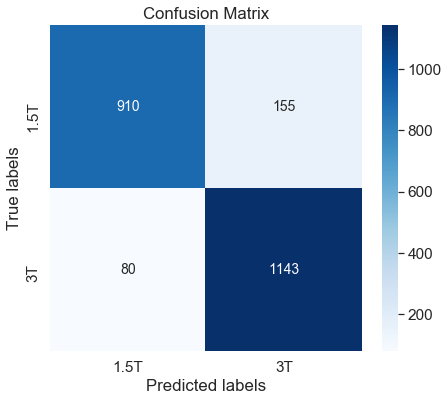

In [43]:
# Confusion matrix
model = load_model("model_FMS.h5")

scores = model.evaluate(X_test, y_test_FMS, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

y_pred = model.predict(X_test)
y_test = np.array(y_test)
classes = ['1.5T', '3T']

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
cmap = plt.cm.Blues

# labels, title and ticks


df_cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (7,6))
sns.set(font_scale=1.4)#for label size
ax= plt.subplot()
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, cmap=cmap, ax = ax, fmt = 'd')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); 
ax.yaxis.set_ticklabels(classes);

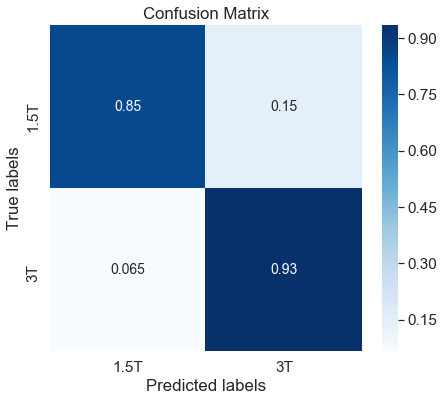

In [44]:
y_pred = model.predict(X_test)
y_test = np.array(y_test)
classes = ['1.5T', '3T']
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmap = plt.cm.Blues

# labels, title and ticks


df_cm = pd.DataFrame(cm, range(2),range(2))

plt.figure(figsize = (7,6))
sns.set(font_scale=1.4)#for label size
ax= plt.subplot()
sns.heatmap(df_cm, annot=True,annot_kws={"size": 14}, cmap=cmap, ax = ax)
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(classes); 
ax.yaxis.set_ticklabels(classes);

In [ ]:
img_idx = 5
raw_dataset[img_idx] = cv.resize(raw_dataset[img_idx], (INPUT_IMAGE_W, INPUT_IMAGE_H), interpolation = cv.INTER_AREA)      # cubic spline interpolation in a 4x4 environment
raw_dataset[img_idx] =  cv.normalize(raw_dataset[img_idx], None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

y = Y['AX', 'SAG', 'COR']
y_label = Y.iloc[img_idx]

y_pred = model.predict(raw_dataset[img_idx])




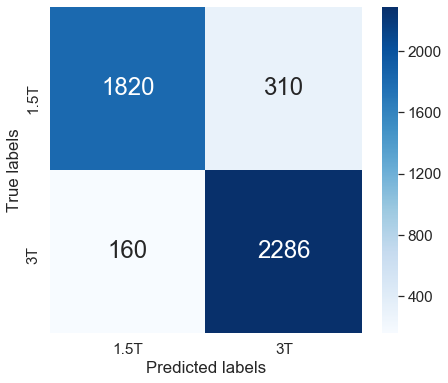

In [3]:
y_pred = np.concatenate((np.zeros(2*910), np.ones(2*155), np.zeros(2*80), np.ones(2*1143)))
y_test = np.concatenate((np.zeros(2*(910 + 155)), np.ones(2*(1143 + 80))))
classes = ['1.5T', '3T']
cm = confusion_matrix(y_test, y_pred)
cmap = plt.cm.Blues

# labels, title and ticks


df_cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (7,6))
sns.set(font_scale=1.4)#for label size
ax= plt.subplot()
sns.heatmap(df_cm, annot=True,annot_kws={"size": 24}, cmap=cmap, ax = ax, fmt = 'd')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
#ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); 
ax.yaxis.set_ticklabels(classes);

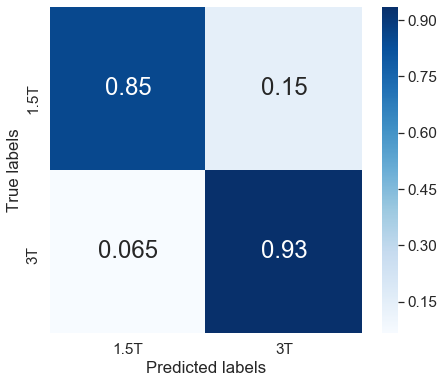

In [10]:
y_pred = np.concatenate((np.zeros(910), np.ones(155), np.zeros(80), np.ones(1143)))
y_test = np.concatenate((np.zeros(910 + 155), np.ones(1143 + 80)))
classes = ['1.5T', '3T']
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmap = plt.cm.Blues

# labels, title and ticks


df_cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (7,6))
sns.set(font_scale=1.4)#for label size
ax= plt.subplot()
sns.heatmap(df_cm, annot=True,annot_kws={"size": 24}, cmap=cmap, ax = ax)
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
#ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); 
ax.yaxis.set_ticklabels(classes);

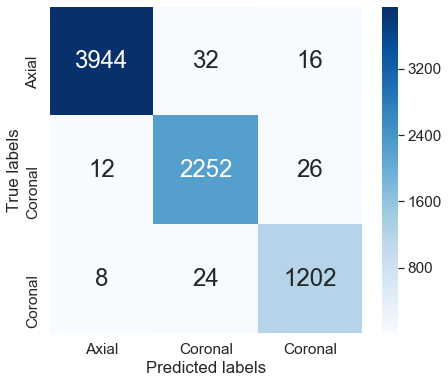

In [12]:
y_pred = np.concatenate((np.zeros(2*1972), np.ones(2*16), 2*np.ones(2*8), np.zeros(2*6), np.ones(2*1126), 2*np.ones(2*13),np.zeros(2*4), np.ones(2*12), 2*np.ones(2*601)))
y_test = np.concatenate((np.zeros(2*(1972 + 16 + 8)), np.ones(2*(6 + 1126 + 13)), 2*np.ones(2*(4 + 12 + 601)) ))
classes = ['Axial', 'Coronal', 'Coronal']
cm = confusion_matrix(y_test, y_pred)
cmap = plt.cm.Blues

# labels, title and ticks


df_cm = pd.DataFrame(cm, range(3),range(3))
plt.figure(figsize = (7,6))
sns.set(font_scale=1.4)#for label size
ax= plt.subplot()
sns.heatmap(df_cm, annot=True,annot_kws={"size": 24}, cmap=cmap, ax = ax, fmt = 'd')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
#ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); 
ax.yaxis.set_ticklabels(classes);

In [10]:
np.concatenate((np.zeros(2*1972), np.ones(2*16), 2*np.ones(2*8), np.zeros(2*6), np.ones(2*1126), 2*np.ones(2*13),np.zeros(2*4), np.ones(2*12), 2*np.ones(2*601)))
               

array([0., 0., 0., ..., 2., 2., 2.])